<a href="https://colab.research.google.com/github/sarveshja/AI_For_Legal_Document_Analysis-_For_Startups/blob/main/AI_for_legal_document_analysis_for_startups_with_6_epoch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

In [ ]:
import transformers
print(transformers.__version__)
print(transformers.__file__)


4.51.1
/usr/local/lib/python3.11/dist-packages/transformers/__init__.py


In [ ]:
!mkdir -p /content/bert_base_uncased
!wget -q https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin -O /content/bert_base_uncased/pytorch_model.bin
!wget -q https://huggingface.co/bert-base-uncased/resolve/main/config.json -O /content/bert_base_uncased/config.json
!wget -q https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt -O /content/bert_base_uncased/vocab.txt

print("✅ Offline model files downloaded!")


✅ Offline model files downloaded!


In [ ]:
from google.colab import files
uploaded = files.upload()

# For this example, we assume you upload a file named "CUADv1.json".
# If you have multiple files, adjust the code accordingly.


Saving CUADv1.json to CUADv1.json
Saving test.json to test.json
Saving train.json to train.json


In [ ]:
import nltk
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import json
from nltk.tokenize import sent_tokenize


# Load the CUAD dataset (adjust filename if needed)
with open('CUADv1.json', 'r') as f:
    cuad_data = json.load(f)

print("Data collected. Number of contracts:", len(cuad_data["data"]))

# Extract candidate clauses from the dataset:
clauses = []  # list of dictionaries: contract title, clause category, original clause text

for contract in cuad_data["data"]:
    contract_title = contract.get("title", "Unknown Contract")
    for para in contract.get("paragraphs", []):
        context = para.get("context", "")
        sentences = sent_tokenize(context)
        for qa in para.get("qas", []):
            clause_category = qa.get("question", "Unknown Category")
            for ans in qa.get("answers", []):
                answer_text = ans.get("text", "").strip()
                # Use a simple heuristic: find the first sentence containing part of the answer
                selected_sentence = None
                for sent in sentences:
                    if answer_text.lower() in sent.lower():
                        selected_sentence = sent
                        break
                if selected_sentence:
                    clauses.append({
                        "contract": contract_title,
                        "clause_category": clause_category,
                        "clause_text": selected_sentence
                    })

print("Extracted", len(clauses), "candidate clauses.")


Data collected. Number of contracts: 510
Extracted 13079 candidate clauses.


In [ ]:
import re
from collections import defaultdict
import pandas as pd

# Convert extracted clauses to a DataFrame
df = pd.DataFrame(clauses)
print("DataFrame shape:", df.shape)
print(df.head())

# Clean clause text: lowercase, remove punctuation, extra spaces
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clause_text_clean'] = df['clause_text'].apply(clean_text)

# Hierarchical organization: group clauses by their category
hierarchy = defaultdict(list)
for _, row in df.iterrows():
    cat = row["clause_category"]
    hierarchy[cat].append(row["clause_text_clean"])

print("Number of clause categories:", len(hierarchy))
for cat, clist in hierarchy.items():
    print(f"Category: {cat} | Number of clauses: {len(clist)}")


DataFrame shape: (13079, 3)
                                            contract  \
0  LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...   
1  LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...   
2  LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...   
3  LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...   
4  LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...   

                                     clause_category  \
0  Highlight the parts (if any) of this contract ...   
1  Highlight the parts (if any) of this contract ...   
2  Highlight the parts (if any) of this contract ...   
3  Highlight the parts (if any) of this contract ...   
4  Highlight the parts (if any) of this contract ...   

                                         clause_text  
0  EXHIBIT 10.6\n\n                              ...  
1  EXHIBIT 10.6\n\n                              ...  
2  EXHIBIT 10.6\n\n                              ...  
3  Any such notice shall be deemed given when so ...  
4  EXHIBIT 10.6\n\n    

Constructed graphs for each category.


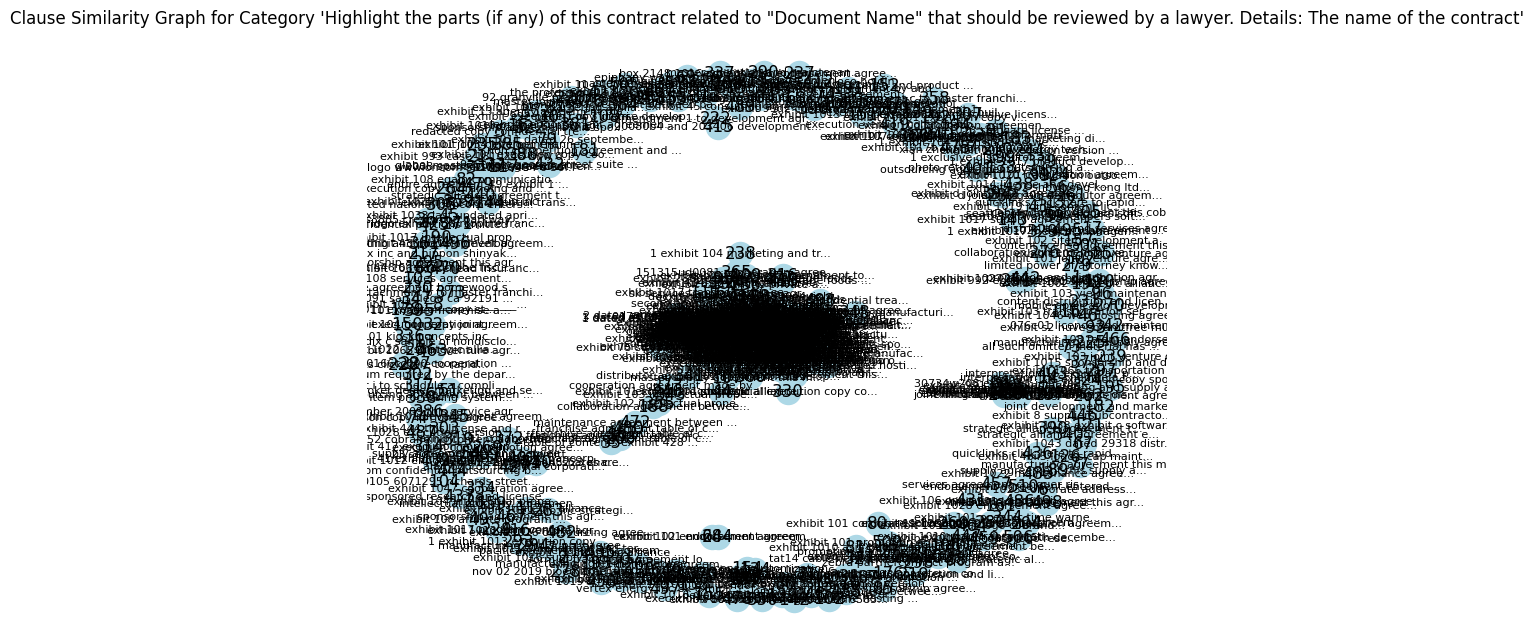

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Jaccard similarity function
def jaccard_similarity(text1, text2):
    words1 = set(text1.split())
    words2 = set(text2.split())
    if not words1 or not words2:
        return 0
    return len(words1.intersection(words2)) / len(words1.union(words2))

# Build a graph for each category: nodes are clauses; add an edge if similarity exceeds threshold.
graphs = {}
similarity_threshold = 0.3  # adjust threshold as needed

for category, clause_list in hierarchy.items():
    G = nx.Graph()
    for i, clause_text in enumerate(clause_list):
        G.add_node(i, text=clause_text)
    for i in range(len(clause_list)):
        for j in range(i+1, len(clause_list)):
            sim = jaccard_similarity(clause_list[i], clause_list[j])
            if sim >= similarity_threshold:
                G.add_edge(i, j, weight=sim)
    graphs[category] = G

print("Constructed graphs for each category.")

# Visualize graph for one example category (with at least 2 nodes)
example_category = None
for cat, G in graphs.items():
    if G.number_of_nodes() > 1:
        example_category = cat
        break

if example_category:
    G = graphs[example_category]
    plt.figure(figsize=(8,6))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
    labels = {i: G.nodes[i]['text'][:30] + "..." for i in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)
    plt.title(f"Clause Similarity Graph for Category '{example_category}'")
    plt.show()
else:
    print("No suitable category for graph visualization found.")


In [ ]:
# For model training, we need a DataFrame with a "contract_text" column and a label.
# We'll use the original clause text as input.
df_train = df.copy()  # For demonstration, using the same data for training and testing
df_test = df.copy()

# Map clause categories to numeric labels
category_mapping = {label: idx for idx, label in enumerate(df_train["clause_category"].unique())}
df_train["category_id"] = df_train["clause_category"].map(category_mapping)
df_test["category_id"] = df_test["clause_category"].map(category_mapping)

# We'll use the cleaned clause text for training.
df_train["contract_text"] = df_train["clause_text_clean"]
df_test["contract_text"] = df_test["clause_text_clean"]

# Display a sample row
print(df_train.head())


                                            contract  \
0  LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...   
1  LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...   
2  LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...   
3  LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...   
4  LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...   

                                     clause_category  \
0  Highlight the parts (if any) of this contract ...   
1  Highlight the parts (if any) of this contract ...   
2  Highlight the parts (if any) of this contract ...   
3  Highlight the parts (if any) of this contract ...   
4  Highlight the parts (if any) of this contract ...   

                                         clause_text  \
0  EXHIBIT 10.6\n\n                              ...   
1  EXHIBIT 10.6\n\n                              ...   
2  EXHIBIT 10.6\n\n                              ...   
3  Any such notice shall be deemed given when so ...   
4  EXHIBIT 10.6\n\n                           

In [ ]:
!pip install datasets

from transformers import BertTokenizer
from datasets import Dataset

# Load tokenizer (we'll later load model offline)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["contract_text"], max_length=512, padding="max_length", truncation=True)

# Convert DataFrame to Dataset
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

# Tokenize datasets in small batches
train_dataset = train_dataset.map(tokenize_function, batched=True, batch_size=16, load_from_cache_file=False)
test_dataset = test_dataset.map(tokenize_function, batched=True, batch_size=16, load_from_cache_file=False)

# Remove columns that are not needed for training
columns_to_remove = ["title", "contract_text", "clause_category", "clause_text", "clause_text_clean", "index"]
train_dataset = train_dataset.remove_columns([col for col in columns_to_remove if col in train_dataset.column_names])
test_dataset = test_dataset.remove_columns([col for col in columns_to_remove if col in test_dataset.column_names])

# Rename label column
train_dataset = train_dataset.rename_column("category_id", "labels")
test_dataset = test_dataset.rename_column("category_id", "labels")

# Set format for PyTorch
train_dataset.set_format("torch")
test_dataset.set_format("torch")

print("✅ Dataset successfully tokenized for model training! 🚀")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/13079 [00:00<?, ? examples/s]

Map:   0%|          | 0/13079 [00:00<?, ? examples/s]

✅ Dataset successfully tokenized for model training! 🚀


In [ ]:
from transformers import BertForSequenceClassification

# Load the model from local directory (offline)
model = BertForSequenceClassification.from_pretrained("/content/bert_base_uncased", num_labels=len(category_mapping))
print("✅ Model loaded from local files!")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /content/bert_base_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded from local files!


In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./clause_classifier",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=6,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sarveshja2003 (sarveshja2003-sri-ramachandta-faculty-of-engineering-and) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,1.052600,0.888207
2,0.945800,0.690282
3,0.703200,0.591043
4,0.632300,0.525039
5,0.561400,0.481938
6,0.561900,0.460812


TrainOutput(global_step=9810, training_loss=0.7900421144765452, metrics={'train_runtime': 9750.3139, 'train_samples_per_second': 8.048, 'train_steps_per_second': 1.006, 'total_flos': 2.065460695251149e+16, 'train_loss': 0.7900421144765452, 'epoch': 6.0})

In [ ]:
model.save_pretrained("./fine_tuned_bert")
tokenizer.save_pretrained("./fine_tuned_bert")
print("✅ Fine-tuned model saved!")

# Reload to verify
model = BertForSequenceClassification.from_pretrained("./fine_tuned_bert")
tokenizer = BertTokenizer.from_pretrained("./fine_tuned_bert")
print("✅ Fine-tuned model reloaded!")


✅ Fine-tuned model saved!
✅ Fine-tuned model reloaded!


In [ ]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.4 MB/s eta 0:00:00


In [ ]:
import evaluate

# Option A: Use Trainer's evaluate method
eval_results = trainer.evaluate()
print("Evaluation results (trainer.evaluate):", eval_results)

# Option B: Use the evaluate library
accuracy_metric = evaluate.load("accuracy")
preds_output = trainer.predict(test_dataset)
predictions = preds_output.predictions.argmax(axis=-1)
labels = preds_output.label_ids
accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
print("Test set Accuracy:", accuracy)


Evaluation results (trainer.evaluate): {'eval_loss': 0.4608118236064911, 'eval_runtime': 368.1122, 'eval_samples_per_second': 35.53, 'eval_steps_per_second': 4.442, 'epoch': 6.0}


Test set Accuracy: {'accuracy': 0.8063307592323572}


In [ ]:
pip install scikit-learn matplotlib


In [ ]:
import evaluate
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc


In [ ]:
# Run predictions using Trainer
preds_output = trainer.predict(test_dataset)
logits = preds_output.predictions
labels = preds_output.label_ids


In [ ]:
from scipy.special import softmax

# For binary classification, you can use sigmoid
# For multi-class classification, use softmax
probs = softmax(logits, axis=1)

# Get the probabilities of the positive class (e.g., class 1)
positive_probs = probs[:, 1]


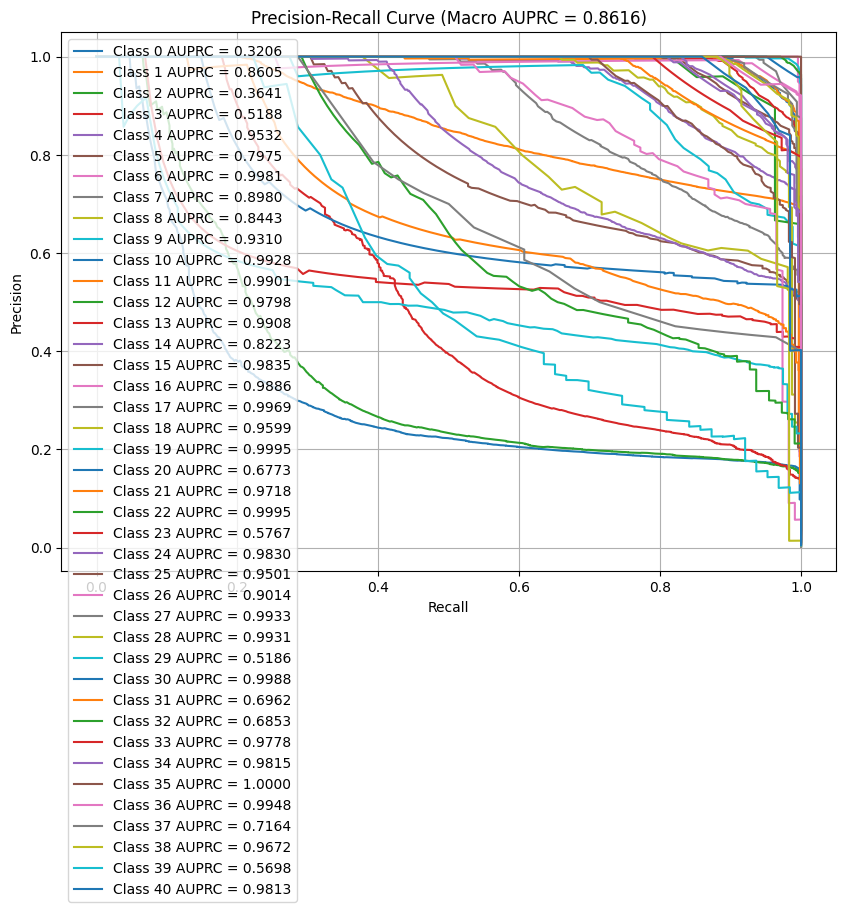

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize
from scipy.special import softmax

# Assume logits and labels already defined
logits = preds_output.predictions
labels = preds_output.label_ids

# Get number of classes
num_classes = logits.shape[1]

# Convert logits to probabilities using softmax
probs = softmax(logits, axis=1)

# Binarize the labels
y_true_bin = label_binarize(labels, classes=np.arange(num_classes))

# Plot setup
plt.figure(figsize=(10, 7))

auprc_scores = []

# Plot PR curve for each class
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], probs[:, i])
    score = auc(recall, precision)
    auprc_scores.append(score)
    plt.plot(recall, precision, label=f"Class {i} AUPRC = {score:.4f}")

# Macro-average AUPRC
macro_auprc = np.mean(auprc_scores)

plt.title(f"Precision-Recall Curve (Macro AUPRC = {macro_auprc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.legend(loc="best")
plt.show()


In [ ]:
import torch

def classify_clause(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    predicted_class = torch.argmax(outputs.logits).item()
    # Create a reverse mapping from numeric labels to clause categories
    reverse_mapping = {v: k for k, v in category_mapping.items()}
    return reverse_mapping[predicted_class]

# Test inference
sample_text = input("Enter a span text:")
predicted_clause = classify_clause(sample_text)
print(f"Predicted Clause: {predicted_clause}")


Enter a span text:The agreement shall remain in effect for three years
Predicted Clause: Highlight the parts (if any) of this contract related to "Expiration Date" that should be reviewed by a lawyer. Details: On what date will the contract's initial term expire?


In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer

model.save_pretrained("./fine_tuned_bert")
tokenizer.save_pretrained("./fine_tuned_bert")

# Check what's inside
import os
print(os.listdir("./fine_tuned_bert"))


['model.safetensors', 'tokenizer_config.json', 'special_tokens_map.json', 'vocab.txt', 'config.json']


In [ ]:
from google.colab import files
import shutil

shutil.make_archive("fine_tuned_bert", 'zip', "./fine_tuned_bert")
files.download("fine_tuned_bert.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save_pretrained("./fine_tuned_bert")
tokenizer.save_pretrained("./fine_tuned_bert")


('./fine_tuned_bert/tokenizer_config.json',
 './fine_tuned_bert/special_tokens_map.json',
 './fine_tuned_bert/vocab.txt',
 './fine_tuned_bert/added_tokens.json')

In [ ]:
import shutil

# Change path as needed
destination = "/content/drive/MyDrive/fine_tuned_bert"
shutil.copytree("./fine_tuned_bert", destination)

print("✅ Model successfully saved to Google Drive!")


✅ Model successfully saved to Google Drive!
